In [2]:
import cv2
import os

def empty_folder(folder):
    # Check if the folder exists
    if not os.path.exists(folder):
        return
    
    # Get the list of files in the folder
    files = os.listdir(folder)
    
    # Loop through the files and remove them
    for file in files:
        file_path = os.path.join(folder, file)
        os.remove(file_path)

def extract_frames(mp4_path, start_frame, end_frame, stride, save_dir='data/mario', size = (64,64)):
    # Open the video file
    video = cv2.VideoCapture(mp4_path)
    empty_folder(save_dir)
    # Get the total number of frames in the video
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total frames in video:", total_frames)
    # Validate the start and end frame numbers
    if start_frame < 0 or start_frame >= total_frames:
        raise ValueError("Invalid start frame number")
    if end_frame < 0 or end_frame >= total_frames:
        raise ValueError("Invalid end frame number")
    if start_frame > end_frame:
        raise ValueError("Start frame number cannot be greater than end frame number")
    
    # Validate the stride value
    if stride <= 0:
        raise ValueError("Stride value must be greater than zero")
    
    # Set the current frame number to the start frame
    current_frame = start_frame
    
    # List to store the extracted frames
    frames = []
    
    # Loop through the frames and extract the desired frames
    while current_frame <= end_frame:
        # Set the current frame number
        video.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
        
        # Read the frame
        ret, frame = video.read()
        
        # Check if the frame was read successfully
        if not ret:
            raise ValueError("Error reading frame")
        
        # Resize the frame to the specified size
        frame = cv2.resize(frame, size)
        # Save the frame to the save_dir
        cv2.imwrite(os.path.join(save_dir, f"frame_{current_frame}.jpg"), frame)
        # Append the frame to the list
        frames.append(frame)
        
        # Increment the current frame number by the stride
        current_frame += stride
    
    # Release the video file
    video.release()
    
    return frames

Frame number: 4000


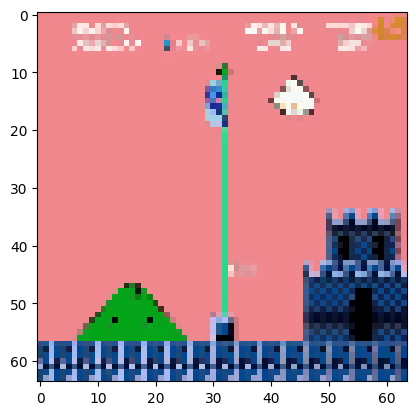

In [37]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

i = 33
for i in range(0, len(frames), 10):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.imshow(frames[i])
    print("Frame number:", start + stride * i)
    plt.show()
    time.sleep(0.03)  # Add a 1-second wait time

In [5]:
path_dir = 'data/mario/'
image_files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]
len(image_files)

721

In [4]:
start = 400
end = 4000
stride = 5
frames = extract_frames("data/videos/mario_gameplay.mp4", start, end, stride, size=(64,64))

Total frames in video: 69878


In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import torch

transform = transforms.Compose([
    transforms.Resize((64, 64)),    # Resize images to 128x128
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])
class marioDataset(Dataset):
    def __init__(self, path_dir, num_frames=4, transform=None):
        self.dir = path_dir
        self.num_frames = num_frames
        self.transform = transform
        self.image_files = [f for f in os.listdir(path_dir) if os.path.isfile(os.path.join(path_dir, f))]

    def __len__(self):
        return len(self.image_files)//self.num_frames 
    
    def __getitem__(self, idx):
        # Load the image from the file
        images = []
        for i in range(self.num_frames):
            img_path = os.path.join(self.dir, self.image_files[idx + i])
            with Image.open(img_path).convert("RGB") as image:
                image = self.transform(image)
                images.append(image)
        images = torch.stack(images)
        return images
    
dataset = marioDataset(path_dir='data/mario/', transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Iterate through the DataLoader
for batch in data_loader:
    print(batch.shape) 

torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size([4, 4, 3, 64, 64])
torch.Size

In [38]:
from torch import nn 
class residualBlock(nn.Module):
    def __init__(self, ni, nf, use_batchnorm=True): 
        super().__init__()
        self.ni = ni
        self.nf = nf
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(nf) if use_batchnorm else nn.Identity()
        self.bn2 = nn.BatchNorm2d(nf) if use_batchnorm else nn.Identity()
        if ni == nf:
            self.skip = nn.Identity()
        else:
            self.skip = nn.Conv2d(ni, nf, kernel_size=1, stride=1)
    def forward(self, x):
        residue = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + self.skip(residue)
        x = self.relu(x)
        return x

class downSample(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class upSample(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.upSample = nn.Upsample(scale_factor=2, mode='nearest')
    def forward(self, x):
        x = self.upSample(x)
        x = self.conv(x)
        x = self.relu(x)
        return x
    
class vae(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            downSample(3, 64),
            residualBlock(64, 64),
            residualBlock(64, 128),
            downSample(128, 128),
            residualBlock(128, 128),
            residualBlock(128, 256),
            downSample(256, 256)
        )
        self.decoder = nn.Sequential(
            upSample(256, 256),
            residualBlock(256, 128),
            residualBlock(128, 128),
            upSample(128, 128),
            residualBlock(128, 64),
            residualBlock(64, 64),
            upSample(64, 3)
        )
        self.loss_func = nn.MSELoss()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std
    
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        loss = self.loss_func(out, x)
        return loss, out, latent

loss: 2.9610
loss: 2.2106
loss: 2.8585
loss: 1.7736
loss: 2.1565
loss: 2.4882
loss: 2.5287
loss: 2.2251
loss: 1.8009
loss: 1.7855
loss: 2.1872
loss: 2.6156
loss: 2.7794
loss: 1.9819
loss: 2.1684
loss: 2.8752
loss: 2.2073
loss: 2.2128
loss: 1.7743
loss: 2.5793
loss: 2.1915
loss: 2.5248
loss: 1.7976
loss: 3.0739
loss: 1.8048
loss: 2.5709
loss: 2.5101
loss: 2.1919
loss: 2.8591
loss: 2.5061
loss: 2.4746
loss: 2.1696
loss: 2.1572
loss: 2.2084
loss: 2.2515
loss: 2.6144
loss: 1.7997
loss: 2.5766
loss: 1.8110
loss: 2.5605
loss: 3.0994
loss: 2.1883
loss: 2.7078
loss: 2.8109
loss: 2.1997
loss: 2.2173
loss: 2.1496
loss: 2.2157
loss: 1.7934
loss: 1.7616
loss: 2.8431
loss: 2.5976
loss: 2.5551
loss: 1.8222
loss: 2.9423
loss: 1.7817
loss: 2.3829
loss: 2.5660
loss: 2.3455
loss: 2.2212
loss: 2.4980
loss: 2.2610
loss: 2.6613
loss: 1.9610
loss: 1.7770
loss: 1.8006
loss: 2.2331
loss: 3.0686
loss: 2.7357
loss: 2.1273
loss: 2.1537
loss: 2.5677
loss: 1.7917
loss: 2.3678
loss: 2.1240
loss: 1.7778
loss: 3.2763

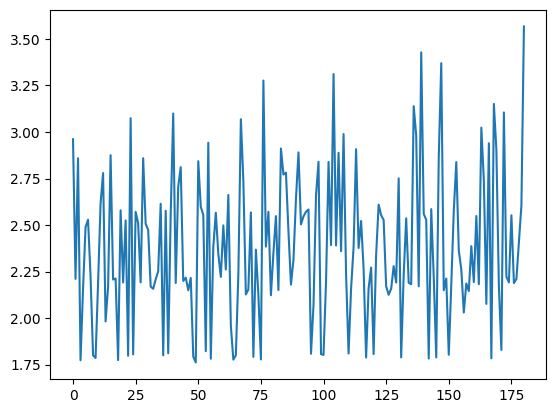

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
our_vae = vae().to(device)
dataset = marioDataset(path_dir='data/mario/',num_frames=1, transform=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)
optimizer = torch.optim.Adam(our_vae.parameters(), lr=0.0001)

losses = []
# Iterate through the DataLoader
i = 1
for batch in data_loader:

    optimizer.zero_grad()
    input = batch.view(-1, 3, 64, 64).to(device)
    loss, _, _ = our_vae(input)
    losses.append(loss.item())
    print(f'loss: {loss.item():.4f}')
    optimizer.step()
    if i == 1000:
        pass
    i += 1 
plt.plot(losses)
